In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers.pooling import AveragePooling2D
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from sklearn.metrics import classification_report
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
from imutils import paths
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pickle
from sklearn.utils import shuffle

In [2]:
dataset='/content/drive/MyDrive/data'
LABELS = set(["Healthy Wheat", "Leaf Rust", "powdery mildew","Wheat Loose Smut" , "Tan Spot" , "Crown and Root Rot"])
imagePaths = list(paths.list_images(dataset))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
 # extract the class label from the filename
 label = imagePath.split(os.path.sep)[-2]
# if the label of the current image is not part of the labels
 # are interested in, then ignore the image
 if label not in LABELS:
    continue
# load the image, convert it to RGB channel ordering, and resize
 # it to be a fixed 224x224 pixels, ignoring aspect ratio
 image = cv2.imread(imagePath)
 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 image = cv2.resize(image, (224, 224))
# update the data and labels lists, respectively
 data.append(image)
 labels.append(label)

In [3]:
data = np.array(data)
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

data = shuffle(data)
labels = shuffle(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
 test_size=0.2, stratify=labels, random_state=42)

In [4]:
print(data.shape)
print(labels.shape)

(4902, 224, 224, 3)
(4902, 6)


In [5]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
 rotation_range=30,
 zoom_range=0.15,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.15,
 horizontal_flip=True,
 fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [6]:
print(trainX.shape)

(3921, 224, 224, 3)


In [7]:
X_train = trainX.reshape(3921, 150528)
from imblearn.over_sampling import SMOTE
sm=SMOTE(random_state=42)
x_smote, y_smote=sm.fit_resample(X_train,trainY)
print(x_smote.shape)
print(y_smote.shape)

(6138, 150528)
(6138, 6)


In [8]:
smote_x=x_smote.reshape(6138,224, 224, 3)

In [9]:
from keras.applications.resnet import ResNet50, preprocess_input
pretrained_model= ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=6,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

In [10]:
pretrained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [11]:
#from tensorflow.keras import layers,Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
resnet_model = Sequential()
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(6, activation='softmax'))
resnet_model.summary()
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 24,639,878
Trainable params: 1,052,166
Non-trainable params: 23,587,712
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
history = resnet_model.fit(trainAug.flow(smote_x, y_smote, batch_size=64), validation_data = valAug.flow(testX, testY), steps_per_epoch = 62, epochs=200)

Epoch 1/60
62/62 [==============================] - 64s 794ms/step - loss: 1.9949 - accuracy: 0.2673 - val_loss: 1.7748 - val_accuracy: 0.2039
Epoch 2/60
62/62 [==============================] - 46s 744ms/step - loss: 1.5926 - accuracy: 0.3160 - val_loss: 1.8100 - val_accuracy: 0.1949
Epoch 3/60
62/62 [==============================] - 46s 741ms/step - loss: 1.5439 - accuracy: 0.3571 - val_loss: 1.7943 - val_accuracy: 0.1990
Epoch 4/60
62/62 [==============================] - 46s 744ms/step - loss: 1.5029 - accuracy: 0.3669 - val_loss: 1.7963 - val_accuracy: 0.2088
Epoch 5/60
62/62 [==============================] - 46s 745ms/step - loss: 1.4855 - accuracy: 0.3902 - val_loss: 1.8117 - val_accuracy: 0.2162
Epoch 6/60
62/62 [==============================] - 46s 745ms/step - loss: 1.4605 - accuracy: 0.3964 - val_loss: 1.8370 - val_accuracy: 0.2072
Epoch 7/60
62/62 [==============================] - 47s 749ms/step - loss: 1.4176 - accuracy: 0.4243 - val_loss: 1.8704 - val_accuracy: 0.2137

KeyboardInterrupt: ignored

In [ ]:
predictions = resnet_model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=lb.classes_))

In [ ]:
N = 200
plt.plot(np.arange(0, N), history.history['accuracy'], label="Training Accuracy")
plt.plot(np.arange(0, N), history.history['val_accuracy'], label="Test Accuracy")
plt.title('resnet50 Model Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()
plt.savefig(r"/content/Accuracy_Plot.png")
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Test Loss")
plt.title('resnet50 Model Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
plt.savefig(r"/content/Loss_Plot.png")

In [ ]:
#Save the Model and label file to Disk
resnet_model.save("/content/activity_model.h5")
f = open("label", "wb")
f.write(pickle.dumps(lb))
f.close()

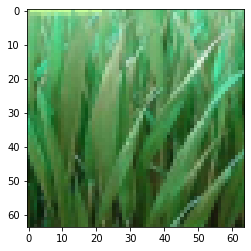

Healthy
85.24495363235474
Leaf rust
0.07042534416541457
Powdery mildew
0.0011494312275317498
Seedlings
8.796852827072144
Septoria
0.004091470327693969
Stem rust
0.0034832977689802647
Yellow Rust
5.879047513008118
PREDICTION: HEALTHY


In [ ]:
from matplotlib import pyplot as plt
model_path = "/content/activity_model.h5"
input = "/content/input_image.jpg"
label = "/content/label"
# load the trained model and label binarizer from disk
moodel = load_model(model_path)
lb = pickle.loads(open("label", "rb").read())
# initialize the image mean for mean subtraction along with the
# predictions queue
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=128)
vs = cv2.VideoCapture(input)
(W, H) = (None, None)
while True:
   (grabbed, frame) = vs.read()
   if not grabbed:
      break
   if W is None or H is None:
      (H, W) = frame.shape[:2]
   output = frame.copy()
   frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
   frame = cv2.resize(frame, (224, 224)).astype("float32")
   frame -= mean
   preds = moodel.predict(np.expand_dims(frame, axis=0))[0]
   Q.append(preds)
   results = np.array(Q).mean(axis=0)
   i = np.argmax(results)
   label = lb.classes_[i]
   text = "PREDICTION: {}".format(label.upper())
   cv2.putText(output, text, (4, 4), cv2.FONT_HERSHEY_SIMPLEX,
      0.25, (200,255,155), 2)
# show the output image
   image=cv2.resize(output,None,fx=0.25,fy=0.25,interpolation=cv2.INTER_AREA)
   plt.imshow(image)
   plt.show()
   for i in range(0,7):
     print(lb.classes_[i])
     print(results[i]*100)
   #print(LABELS)
   #print(results)
   print(text)
   key = cv2.waitKey(10) & 0xFF
 
   # if the `q` key was pressed, break from the loop
   if key == ord("q"):
     break
vs.release()